In [4]:
#essential imports
import pandas as pd
import numpy as np

import datetime as dt
import time

# Strict JSON conversion
import json 
import gzip 

#garbage collector
import gc

startyear=1990
startmonth=1

cps = 4
datapath = 'DATA/review_filtered/'
f_subjects = datapath+'movie_reviews_matched_'+str(cps)+'cps.csv'
f_controls = datapath+'movie_reviews_matched_'+str(cps)+'cps_ctrls.csv'

# Load data

In [5]:
subjects_actors = pd.read_csv(f_subjects).drop('Unnamed: 0',axis=1)
subjects_actors = subjects_actors.rename(columns={'reviewTime' : 'strReviewTime'})
subjects_actors.head(3)

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,death date
0,308659,0792840461,2006-04-07,4.0,"[1, 3]",The orginal,The Original and the best-not much to say read...,jack weston,1996-05-03
1,308660,0792840461,2013-03-24,5.0,"[0, 0]",Steve McQueen invented cool,This was a great movie Steve McQueen invented ...,jack weston,1996-05-03
2,308661,0792840461,2014-04-05,4.0,"[1, 1]",Where The Dough Is,"Everybody knows banks, whether in storefronts,...",jack weston,1996-05-03


In [6]:
controls_actors = pd.read_csv(f_controls).drop('Unnamed: 0',axis=1)
controls_actors = controls_actors.rename(columns={'reviewTime' : 'strReviewTime'})
controls_actors.head(3)

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name
0,827321,630327417X,2009-10-15,5.0,"[0, 1]",Great Movie,Nothing bad to say. Dvd came quickly and in gr...,michael hynson
1,827322,630327417X,2000-09-16,5.0,"[0, 0]",endless summer,its just to good for words!,michael hynson
2,827323,630327417X,2005-03-03,1.0,"[5, 58]",A very disappointed lover of documentaries,I feel obligated to warn you-as I wish I was w...,michael hynson


# Convert dates to timestamps / years

Convert dates to year and extract and set aside actor<-> deathdates

In [7]:
subjects_actors.head()

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,death date
0,308659,0792840461,2006-04-07,4.0,"[1, 3]",The orginal,The Original and the best-not much to say read...,jack weston,1996-05-03
1,308660,0792840461,2013-03-24,5.0,"[0, 0]",Steve McQueen invented cool,This was a great movie Steve McQueen invented ...,jack weston,1996-05-03
2,308661,0792840461,2014-04-05,4.0,"[1, 1]",Where The Dough Is,"Everybody knows banks, whether in storefronts,...",jack weston,1996-05-03
3,308662,0792840461,2012-12-21,2.0,"[3, 3]","great movie,but PLEASE avoid this copy.",an all-time great movie and one of my favorite...,jack weston,1996-05-03
4,308663,0792840461,2013-05-12,5.0,"[0, 0]",It's McQueen,Fans of a rough and tough McQueen know that th...,jack weston,1996-05-03


In [8]:
#counts = subjects_actors.groupby('actor name').count()
#subjects_actors['death date'] = pd.to_datetime('2001').year

''' Takes a serie !
'''
def strdateToMonth(date) : 
    year = int(str(date)[:4])
    month = int(str(date)[5:7])
    assert(month <= 12 and month >= 1)
    return (month - startmonth) + (year - startyear)*12 

''' Takes a serie !
'''
def strdateToYear(date) : 
    return int(str(date)[:4])

# SUBJECTS
subjects_actors['reviewMonth'] = subjects_actors['strReviewTime'].apply(strdateToMonth)
subjects_actors['reviewYear'] = subjects_actors['strReviewTime'].apply(strdateToYear)
subjects_actors['reviewTime'] = pd.to_datetime(subjects_actors['strReviewTime'])
subjects_actors['death month'] = subjects_actors['death date'].apply(strdateToMonth)
subjects_actors['death year'] = subjects_actors['death date'].apply(strdateToYear)
subjects_actors['death date'] = pd.to_datetime(subjects_actors['death date'])

# CONTROLS
controls_actors['reviewMonth'] = controls_actors['strReviewTime'].apply(strdateToMonth)
controls_actors['reviewYear'] = controls_actors['strReviewTime'].apply(strdateToYear)
controls_actors['reviewTime'] = pd.to_datetime(controls_actors['strReviewTime'])

Extract death dates and subjects names

In [9]:
deathdates = subjects_actors.groupby(['actor name','death date', 'death year', 'death month']).count()\
                            .reset_index()[['actor name', 'death date', 'death year', 'death month']]
sbj_names = list(deathdates['actor name'])
deathdates.head()

,actor name,death date,death year,death month
0,adriana caselotti,1997-01-19,1997,84
1,adrienne shelly,2006-11-01,2006,202
2,al martino,2009-10-13,2009,237
3,alain bashung,2009-03-14,2009,230
4,alan bates,2003-12-27,2003,167


Extract controls names

In [10]:
ctrl_names = list(set(controls_actors['actor name']))

# Pre-filtering

### Filtering on populatiry

Filter actors based on their popularity: they should be mentioned at least once in the reviews. It is a way to be sure the reviewers know the actor.

In [11]:
thresh_pop = 1

def mentionsName(row) : 
    if type(row['reviewText']) is str :
        names = row['actor name'].split(' ')
        text =  row['reviewText'].lower()
        # can mention only name or surname
        #return row['actor name'] in row['reviewText']
        for name in names : 
            if name in text : 
                return True
        return False
    else : return False

In [12]:
subjects_actors.head()

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,death date,reviewMonth,reviewYear,reviewTime,death month,death year
0,308659,0792840461,2006-04-07,4.0,"[1, 3]",The orginal,The Original and the best-not much to say read...,jack weston,1996-05-03,195,2006,2006-04-07,76,1996
1,308660,0792840461,2013-03-24,5.0,"[0, 0]",Steve McQueen invented cool,This was a great movie Steve McQueen invented ...,jack weston,1996-05-03,278,2013,2013-03-24,76,1996
2,308661,0792840461,2014-04-05,4.0,"[1, 1]",Where The Dough Is,"Everybody knows banks, whether in storefronts,...",jack weston,1996-05-03,291,2014,2014-04-05,76,1996
3,308662,0792840461,2012-12-21,2.0,"[3, 3]","great movie,but PLEASE avoid this copy.",an all-time great movie and one of my favorite...,jack weston,1996-05-03,275,2012,2012-12-21,76,1996
4,308663,0792840461,2013-05-12,5.0,"[0, 0]",It's McQueen,Fans of a rough and tough McQueen know that th...,jack weston,1996-05-03,280,2013,2013-05-12,76,1996


In [13]:
subjects_actors['mentionned'] = subjects_actors.apply(mentionsName, axis=1)
subjects_actors.shape, subjects_actors[subjects_actors['mentionned']==True].shape

((597276, 15), (130234, 15))

In [14]:
## Not necessarily needed, count of mentions are still in the reviews dataframe
##
sbj_popular = subjects_actors[subjects_actors['mentionned']==True]
sbj_popular = sbj_popular.groupby('actor name').count()['asin']
print(len(sbj_names), " reduced to", sbj_popular.shape)
sbj_popular.sort_values(ascending=False)[:10]

501  reduced to (460,)


actor name
james stewart        4135
paul newman          3119
charlton heston      3031
gregory peck         2618
marlon brando        2592
jack lemmon          2367
james garner         2347
katharine hepburn    2293
robert mitchum       2089
charles bronson      2028
Name: asin, dtype: int64

In [15]:
controls_actors['mentionned'] = controls_actors.apply(mentionsName, axis=1)
controls_actors.shape, controls_actors[controls_actors['mentionned']==True].shape

((285071, 12), (42178, 12))

In [16]:
## Not necessarily needed, count of mentions are still in the reviews dataframe
##
ctl_popular = controls_actors[controls_actors['mentionned']==True]
ctl_popular = ctl_popular.groupby('actor name').count()['asin']
print(len(ctrl_names), " reduced to", ctl_popular.shape)
ctl_popular.sort_values(ascending=False)[:10]

2419  reduced to (1215,)


actor name
matt damon            6017
steve martin          3266
tyler perry           2870
ian anderson          1213
laurence fishburne    1198
liev schreiber        1060
michelle williams     1058
marc m                 896
maggie gyllenhaal      867
robert taylor          749
Name: asin, dtype: int64

### Filtering on date (2004-2013)

In [17]:
start = 1996
end = 2014

print('original size : ', subjects_actors.shape)
subjects_inTime = subjects_actors[    (subjects_actors['death year']>=start) \
                                    & (subjects_actors['death year']<=end)]
print('filtered size : ', subjects_inTime.shape)
subjects_inTime.head(3)

original size :  (597276, 15)
filtered size :  (597276, 15)


,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,death date,reviewMonth,reviewYear,reviewTime,death month,death year,mentionned
0,308659,0792840461,2006-04-07,4.0,"[1, 3]",The orginal,The Original and the best-not much to say read...,jack weston,1996-05-03,195,2006,2006-04-07,76,1996,False
1,308660,0792840461,2013-03-24,5.0,"[0, 0]",Steve McQueen invented cool,This was a great movie Steve McQueen invented ...,jack weston,1996-05-03,278,2013,2013-03-24,76,1996,False
2,308661,0792840461,2014-04-05,4.0,"[1, 1]",Where The Dough Is,"Everybody knows banks, whether in storefronts,...",jack weston,1996-05-03,291,2014,2014-04-05,76,1996,False


# Get matching features

Extract features for subjects

In [18]:
nbMonthBeforeDeath = 2
relMonthBeforeDeath = [-i for i in range(1, nbMonthBeforeDeath+1)]
relFeaturesStr = { i : 'revs'+str(i) for i in relMonthBeforeDeath}
#relFeaturesStr

In [86]:
# SUBJECTS COUNTS BY MONTH
subjects_monthly_revs = subjects_actors.groupby(['actor name','reviewMonth']).count()


''' MonthNb is relative to death time, so monthNb=-1 for deathMonth=March 
    means February
'''
def getreview_month_subjects(row, relMonth) : 
    return getreview_month(row, relMonth, subjects_monthly_revs)
def getreview_month(row, monthNb, musiciansDataframe, deathMonth=None) : 
    actor = row['actor name']
    if deathMonth==None : 
        deathMonth = int(row['death month'])
    try : 
        val = subjects_monthly_revs.loc[actor, int(deathMonth+monthNb)]['asin']
        return val
    except TypeError :
        #print('typeError cant index at -->'+str(deathmonth+monthNb)+'<--')
        return 0
    
subjects_monthly_feats = pd.DataFrame(deathdates[['actor name', 'death month']])
for i in relMonthBeforeDeath :
    subjects_monthly_feats[relFeaturesStr[i]] = subjects_monthly_feats\
                                        .apply(lambda row : getreview_month_subjects(row, i), axis=1)

def feature_norm(row) : 
    feature = [row[relFeaturesStr[i]] for i in relMonthBeforeDeath]
    return np.linalg.norm(feature)

subjects_monthly_feats['featureNorm'] = subjects_monthly_feats.apply(feature_norm, axis=1)
        
subjects_monthly_feats.sort_values(by='featureNorm', ascending=False).head()

,actor name,death month,revs-1,revs-2,featureNorm
228,james garner,294,151,178,233.420222
357,mickey rooney,291,149,156,215.724361
140,eli wallach,293,120,138,182.877008
389,philip seymour hoffman,289,119,106,159.364362
288,karen black,283,74,111,133.405397


In [20]:
# SUBJECTS COUNTS BY YEAR
subjects_revs = subjects_actors.groupby(['actor name','reviewYear']).count()


def getreview(actor, year) : 
    try : 
        val = subjects_revs.loc[actor, year]['asin']
        return val
    except TypeError :
        return 0
    
    

# FILTER TO GET THE DEATH YEAR COUNT - 1
subjects_feats = deathdates[1:].apply(lambda row : getreview(row['actor name'], int(row['death year'])-1), axis=1)
subjects_feats = pd.DataFrame(subjects_feats, columns=['reviews'])
subjects_feats['actor name'] = deathdates['actor name']
subjects_feats['death year'] = deathdates['death year']
subjects_feats['death date'] = deathdates['death date']

subjects_feats.sort_values(by='reviews', ascending=False).head()

,reviews,actor name,death year,death date
228,2054,james garner,2014,2014-07-19
389,1550,philip seymour hoffman,2014,2014-02-02
357,1425,mickey rooney,2014,2014-04-06
140,1112,eli wallach,2014,2014-06-24
51,1057,bob hoskins,2014,2014-04-29


Extract features for controls (?)

In [21]:
controls_revs = controls_actors.groupby(['actor name','reviewMonth'])\
                                .count()['asin']\
                                .to_frame().reset_index()

In [22]:
controls_revs.sort_values(by=['actor name', 'asin'], ascending=False).head()

,actor name,reviewMonth,asin
49759,zuzana parmova,143,1
49760,zuzana parmova,168,1
49743,zuhal gencer,185,2
49740,zuhal gencer,180,1
49741,zuhal gencer,182,1


# Matching

Construct a matching function per subject

In [63]:
# copy back above
def getreview_month_controls(row, monthNb, musiciansDataframe, deathMonth=None) : 
    actor = row['actor name']
    if deathMonth==None : 
        deathMonth = int(row['death month'])
    try : 
        val = musiciansDataframe.loc[actor, int(deathMonth+monthNb)]['asin']
        return int(val)
    ## Both exceptions can happen when the indexing keys are 
    ## not in the index == when there were no review for the actor at the given month
    except TypeError :
        #print('key (', actor, ', '+str(deathMonth+monthNb)+') returned typeError')
        return 0
    except KeyError :
        #print('key (', actor, ', ', deathMonth, ') found no match in the index')
        return 0

In [77]:
subjects_monthly_feats.head()
controls_revs.set_index(['actor name','reviewMonth']).loc['adrian holmes']
controls_revs.groupby('actor name').count().reset_index()

,actor name,reviewMonth,asin
0,aaron chayrez,1,1
1,aaron kwok,60,60
2,aarti chopra,2,2
3,abdul salaam el razzac,5,5
4,adam clark,19,19
5,adam jones,22,22
6,adam monty,29,29
7,adrian holmes,55,55
8,adriana bello,1,1
9,adriana mather,7,7


In [130]:
def unwrap(subjectStuff) : 
    return subjectStuff.tolist()[0]

def match(actorname, threshold, ctrl_revs) : 

    # extract the useful features for the subject 
    sbj_actor = subjects_monthly_feats[subjects_monthly_feats['actor name'] == actorname]
    deathmonth = int(sbj_actor['death month'])
    sbjname = unwrap(sbj_actor['actor name'])
    feature = [unwrap(sbj_actor[relFeaturesStr[i]]) for i in relMonthBeforeDeath]
    
    #print(sbj_actor)
    #print('feature : ', feature)
    
    for control in ctrl_revs.groupby('actor name').count().reset_index().iterrows() : 
        
        # iterrows returns tuple (0, row)
        idx = control[0]
        control = control[1]
        
        
        if idx % 700 == 0 and idx !=0 : 
            print('    iterated over ', idx, 'controls (out of ', 
                  ctrl_revs.groupby('actor name').count().reset_index().shape[0], ')')
        
        
        # Compute feature
        ctrl_feature = [getreview_month_controls(control, i, 
                                        ctrl_revs.set_index(['actor name', 'reviewMonth']), 
                                        deathMonth=deathmonth) \
                        for i in relMonthBeforeDeath]
        
        #print('   ctrl_feature : ', ctrl_feature )
        
        diff = np.linalg.norm(np.array(feature) - np.array(ctrl_feature))
        
        #print('    diff : ', diff)
        
        #if diff <= threshold and sum(feature)<sum(ctrl_feature) : 
        if diff <= threshold : 
            print('checking ', sbjname, 'at', feature, ' VS ', control['actor name'], 'at', ctrl_feature )
            
            
            matched_name = control['actor name']
            matched_count = ctrl_feature

            #ctrl_revs = ctrl_revs[ctrl_revs['actor name'].isin([matched_name])==False]
            ctrl_revs = ctrl_revs[ctrl_revs['actor name']!=matched_name]

            print('  ',sbjname, ' matched with ', matched_name, 'at thresh ', threshold )
            print('    ', feature, ' ~ ' , ctrl_feature)
            return matched_name, ctrl_feature, ctrl_revs
        
            
            # We want a stricter threshold if the control has more reviews than the subject, because controls 
            # with high reviews numbers are rare so we-d like to keep them for high reviews numbers subjects
            sbj_reviews = sum(feature)
            ctl_reviews = sum(ctrl_feature)
            
            
            if (    (ctl_reviews > sbj_reviews and diff <= threshold*0.85) 
                or  (sbj_reviews > ctl_reviews and diff<= threshold)
               ):
                matched_name = control['actor name']
                matched_count = ctrl_feature

                #ctrl_revs = ctrl_revs[ctrl_revs['actor name'].isin([matched_name])==False]
                ctrl_revs = ctrl_revs[ctrl_revs['actor name']!=matched_name]

                print('  ',sbjname, ' matched with ', matched_name, 'at thresh ', threshold )
                print('    ', feature, ' ~ ' , ctrl_feature)
                return matched_name, ctrl_feature, ctrl_revs

    print('    1 control iteration completed')
    return 0, 0, ctrl_revs  


In [ ]:
ctrl_revs = controls_revs.copy()
print(len(ctrl_names), len(sbj_names))

thresh = 10
ctrl_revs = controls_revs.copy()
sorted_subjects = subjects_monthly_feats.sort_values(by='featureNorm', ascending=False)
res_sbjs = []
res_sbjs_feats = []
res_ctls = []
res_ctls_feats = []

for idx, subject_name in enumerate(sorted_subjects['actor name']):
    
    if idx%30 == 0: 
        print(idx, " subjects out of ", len(subjects_feats['actor name']))
        
    # extract the feature for the subject and use it to set the threshold
    sbj_actor = sorted_subjects[sorted_subjects['actor name'] == subject_name]
    featureNorm = sbj_actor['featureNorm']  
    
    thr = int(8 + 0.06*featureNorm)
    mtch = 0

    while mtch == 0:
        
        if thr > 50 and thr < 60  : 
            print(subject_name+' reached threshold ', thr)
        if thr > 1000 and thr < 1250  : 
            print(subject_name+' reached threshold ', thr)
        if thr > 10000 : 
            print(subject_name+' reached threshold > 10000 (probably won\'t match)')
        
        name, ctrl_feature, ctrl_revs_ = match(subject_name,thr,ctrl_revs)
        ctrl_revs = ctrl_revs_.sample(frac=1) 
        
        
        if name != 0:
            #print(subject_name+' matched with '+name)
            
            
        
            res_sbjs.append(subject_name)
            res_ctls.append(name)
            res_sbjs_feats.append(feature)
            res_ctls_feats.append(ctrl_feature)
            mtch += 1
            
        else : 
            thr += int(0.5*thr)
            print('  increasing thr : ', thr)
        
            
print('DONE')

2419 501
0  subjects out of  500
    iterated over  700 controls (out of  2419 )
    iterated over  1400 controls (out of  2419 )
    iterated over  2100 controls (out of  2419 )
    1 control iteration completed
  increasing thr :  33
    iterated over  700 controls (out of  2419 )
checking  james garner at [151, 178]  VS  laurence fishburne at [144, 155]
   james garner  matched with  laurence fishburne at thresh  33
     [151, 178]  ~  [144, 155]
    iterated over  700 controls (out of  2418 )
    iterated over  1400 controls (out of  2418 )
checking  mickey rooney at [149, 156]  VS  peter krause at [157, 173]
   mickey rooney  matched with  peter krause at thresh  20
     [149, 156]  ~  [157, 173]
    iterated over  700 controls (out of  2417 )
    iterated over  1400 controls (out of  2417 )
checking  eli wallach at [120, 138]  VS  michael kelly at [104, 137]
   eli wallach  matched with  michael kelly at thresh  18
     [120, 138]  ~  [104, 137]
    iterated over  700 controls (o

# Results

In [22]:
ctrl_features = pd.DataFrame(ctrl_list, columns=['ctrl_name'])
ctrl_features['ctrl_reviews'] = count_list

res = pd.concat([ctrl_features.reset_index(), sorted_subjects.reset_index()], axis=1)\
            .drop('index', axis=1)
res['error'] = np.abs(res['ctrl_reviews'] - res['reviews'])/(2*(1+res['ctrl_reviews'] + res['reviews']))

res.sort_values(by='error', ascending=False).head()

,ctrl_name,ctrl_reviews,reviews,actor name,death year,death date,error
145,stuart reeder,6,45,jason robards,2000,2000-12-26,0.375000
250,willie chan,1,5,francis lederer,2000,2000-05-25,0.285714
255,józsef madaras,1,5,jane greer,2001,2001-08-24,0.285714
248,ching ching yiu,1,5,glenn quinn,2002,2002-12-03,0.285714
263,tyrone power sr,1,4,david tomlinson,2000,2000-06-24,0.250000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ddd0e5908>]], dtype=object)

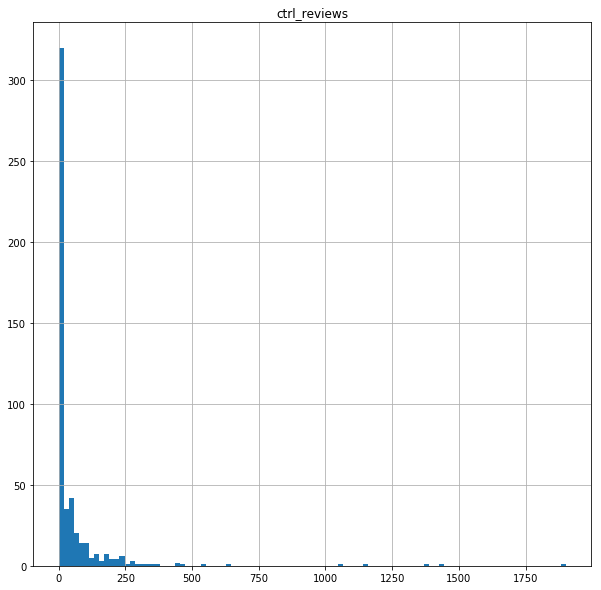

In [23]:
ctrl_features.hist(column='ctrl_reviews', figsize=[10,10], bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ddd014780>]], dtype=object)

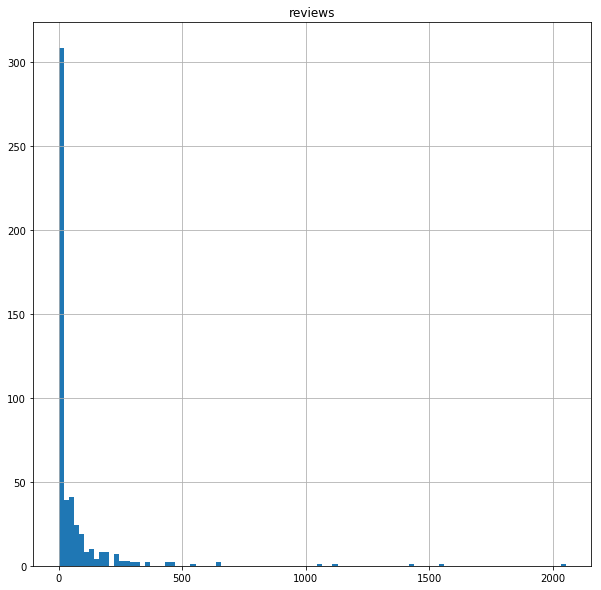

In [24]:
subjects_feats.hist(column='reviews', figsize=[10,10], bins=100)

# Export results

In [25]:
subjectsnb = str(len(sbj_names)-1)

In [26]:
subjects_actors.to_csv('DATA/reviews_cs_matched/reviews_subjects_'+subjectsnb+'.csv', index=False)

In [27]:
controls_actors.to_csv('DATA/reviews_cs_matched/reviews_controls_'+subjectsnb+'.csv', index=False)

In [28]:
res.to_csv('DATA/reviews_cs_matched/matchings_'+subjectsnb+'_feature=yearbefore.csv', index=False)